<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/02_dnn_simple_pytorch/CIFAR_CNN_MYDATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPyTorchで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．


In [1]:
# モジュールのインポート
import numpy as np
from time import time
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torchsummary

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## データセットの読み込みと確認
学習データ（CIFAR10データセット）を読み込みます．

読み込んだ学習データのサイズを確認します．
学習データは5万枚，1つのデータサイズは3x32x32の画像のような形式となっています．
これは32x32ピクセルのカラー画像という意味になります．

In [2]:
train_data = torchvision.datasets.CIFAR10(root="./", train=True, transform=transforms.ToTensor(), download=True)

print(train_data)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()


## ネットワークモデルの定義

畳み込みニューラルネットワークを定義します．

ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．

1層目の畳み込み層は入力チャンネル数が1，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．
2層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．
１つ目の全結合層は入力ユニット数は`7*7*32`とし，出力は1024としています．
次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．
また，活性化関数として`self.act`にシグモイド関数を定義します．
さらに，プーリング処理を行うための`self.pool`を定義します．
ここでは，maxpoolingを使用します．
これらの各層の構成を`__init__`関数で定義します．

次に，`forward`関数では，定義した層を接続して処理するように記述します．
`forward`関数の引数`x`は入力データです．
それを`__init__`関数で定義した`conv1`に入力し，その出力を活性化関数である`self.act`に与えます．
そして，その出力を`self.pool`に与えて，プーリング処理結果を`h`として出力します．
2層目の畳み込み層でも同様の手順で処理を行います．

畳み込みを適用した後の特徴マップを全結合層へと入力して，識別結果を出力します．
まず．畳み込みによって得られた特徴マップの形状（チャンネルx縦x横）を1次元の配列へと変換します．
ここで，`view()`を用いることで，`h`の配列を操作します．引数として，変換したい配列のサイズを入力します．
まず一つ目の引数の`h.size()[0]`で，`h`の1次元目のサイズを取得し，変換後の配列の1次元目のサイズとして指定します．
二つ目の引数の`-1`で任意のサイズを指定します．
これにより，`h`を（バッチ数x任意の長さのデータ）の形状へ変換します．
変換した`h`を全結合層および活性化関数へと順次入力することで，最終的にクラススコアを返します．

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(8 * 8 * 32, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．

`CNN`クラスを呼び出して，ネットワークモデルを定義します．
また，GPUを使う場合（`use_cuda == True`）には，ネットワークモデルをGPUメモリ上に配置します．
これにより，GPUを用いた演算が可能となります．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．
また，学習率を0.01，モーメンタムを0.9として引数に与えます．

In [4]:
model = CNN()
if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                 [-1, 1024]       2,098,176
              ReLU-8                 [-1, 1024]               0
            Linear-9                 [-1, 1024]       1,049,600
             ReLU-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 3,163,114
Trainable params: 3,163,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

## 学習
読み込んだMNISTデータセットと作成したネットワークを用いて，学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を64，学習エポック数を10とします．

次にデータローダーを定義します．
データローダーでは，上で読み込んだデータセット（`train_data`）を用いて，for文で指定したミニバッチサイズでデータを読み込むオブジェクトを作成します．
この時，`shuffle=True`と設定することで，読み込むデータを毎回ランダムに指定します．

次に，誤差関数を設定します．
今回は，分類問題をあつかうため，クロスエントロピー誤差を計算するための`CrossEntropyLoss`を`criterion`として定義します．

学習を開始します．

各更新において，学習用データと教師データをそれぞれ`image`と`label`とします．
学習モデルにimageを与えて各クラスの確率yを取得します．
各クラスの確率yと教師ラベルtとの誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [5]:
# ミニバッチサイズ・エポック数の設定
batch_size = 64
epoch_num = 10
n_iter = len(train_data) / batch_size

# データローダーの設定
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()

start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)
        
        loss = criterion(y, label)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)
        
    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time :{}".format(epoch,
                                                                                 sum_loss / n_iter,
                                                                                 count.item() / len(train_loader),
                                                                                 time() - start))

epoch: 1, mean loss: 1.846470560760498, mean accuracy: 20.78388746803069, elapsed_time :15.92044973373413
epoch: 2, mean loss: 1.3672926894378663, mean accuracy: 32.13427109974425, elapsed_time :33.744306325912476
epoch: 3, mean loss: 1.156839063796997, mean accuracy: 37.55882352941177, elapsed_time :49.20323920249939
epoch: 4, mean loss: 0.9927894921875, mean accuracy: 41.448849104859335, elapsed_time :65.9617190361023
epoch: 5, mean loss: 0.8665868920898437, mean accuracy: 44.28132992327366, elapsed_time :85.0137836933136
epoch: 6, mean loss: 0.7346456479263306, mean accuracy: 47.38363171355499, elapsed_time :100.63436841964722
epoch: 7, mean loss: 0.602888935432434, mean accuracy: 50.373401534526856, elapsed_time :116.15855288505554
epoch: 8, mean loss: 0.46698528783798215, mean accuracy: 53.34526854219949, elapsed_time :131.65439414978027
epoch: 9, mean loss: 0.33445342794418337, mean accuracy: 56.42199488491048, elapsed_time :147.41980528831482
epoch: 10, mean loss: 0.244232443213

## オレオレデータを読み込むプログラム

**準備**
*   Google Driveにデータをアップロード
*   例："My_Data"というフォルダ名にしてアップロード
*   My_Dataに"airplane"，"cat"といったフォルダを作成
*   その中に画像ファイルを入れる


つまり，Google Driveの"My_Data"内は"My_Data/hoge/image.jpeg"が入っています

$ {\rm hoge} \in\ \{ {\rm airplane}, {\rm automobile}, \ldots, {\rm truck} \}$, 
$ {\rm image} \in\ \{ {\rm 1}, {\rm 2}, \ldots, {\rm n} \}$





In [7]:
import os
import sys
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image, ImageFilter
from google.colab import drive

# Google Driveをインポート
drive_path = '/content/drive'
drive.mount(drive_path)

# オレオレデータフォルダを読み込みます
# パスは'/content/drive/MyDrive/My_Data/hoge'のようになり，リスト化されています
# hogeはフォルダ名で，フォルダ下に01.jpeg，02.jpeg，...とそれぞれファイルが格納されているとそのまま動きます
paths = sorted(glob(os.path.join(drive_path+"/MyDrive/My_Data/*")))
print(paths)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/My_Data/airplane', '/content/drive/MyDrive/My_Data/automobile', '/content/drive/MyDrive/My_Data/bird', '/content/drive/MyDrive/My_Data/cat', '/content/drive/MyDrive/My_Data/deer', '/content/drive/MyDrive/My_Data/dog', '/content/drive/MyDrive/My_Data/frog', '/content/drive/MyDrive/My_Data/horse', '/content/drive/MyDrive/My_Data/ship', '/content/drive/MyDrive/My_Data/truck']


MyDatasetでオレオレデータセットを読み込みます

In [8]:
# 今回はCIFAR-10pre-trainedモデルを使うので，教師ラベルは以下で定義
label_names = np.array([
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"])

# オレオレデータローダを作成します．
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform = None):
        self.transform = transform
        # ここでオレオレデータファイルのパスを取得します
        # 拡張子が".jpeg"になっていますが，".png"などでも動きます
        list_data = [sorted(glob(os.path.join(file_path, '*.jpeg'))) for file_path in paths]
        # リストをフラット化
        self.data = sum(list_data, [])

    # オレオレデータファイルの数
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        # 教師ラベルの定義をします
        label = os.path.basename(os.path.dirname(data))
        label = np.where(label == label_names)
        # ファイルパスから画像データを読み込む
        data = Image.open(data)
        data = self.transform(data)
        return data, label[0]

CIFAR-10pre-trainedモデルを使って評価してみます

test accuracy: 0.75


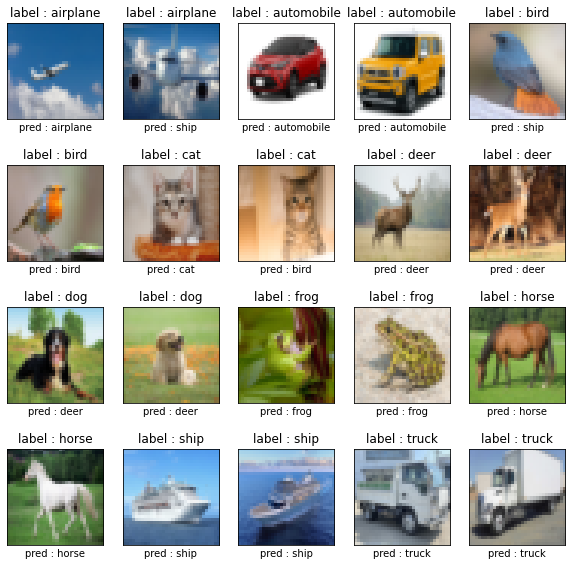

In [11]:
# CIFAR-10に合わせて32x32にリサイズ
transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
])

test_data = MyDataset(paths, transform=transform_test)
# データローダーの準備
batch_size = 1
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

plt.figure(figsize=[10, 10])
# 評価の実行
count = 0
num = 1
with torch.no_grad():
    for image, label in test_loader:
        label = torch.flatten(label)

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

        # 画像の表示
        # 上が教師ラベル，下が予測ラベルになります．
        for b in range(batch_size):
            # 4, 5は行，列を表すので，オレオレデータ数によって変わります
            # 今回のデータは全部で20枚(各ラベル2枚ずつ)あるので，この数で指定しています
            plt.subplot(4, 5, b+num)
            plt.imshow(image[b].permute(1,2,0).detach().cpu().numpy())
            plt.title("label : " + label_names[label[b]])
            plt.xlabel("pred : " + label_names[pred[b]])
            plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            plt.tick_params(bottom=False, left=False, right=False, top=False)
        num += batch_size

print("test accuracy: {}".format(count.item() / (len(test_loader)*batch_size)))
plt.show()